In [1]:
# first time setup only
#!python ./fetch_dataset.py
#!unzip ./frames.zip # only for first time setup

# mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# move to the git repo
%cd /content/drive/Shareddrives/StellarSummarizers/the-stellar-summarizers-sp22

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/StellarSummarizers/the-stellar-summarizers-sp22


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models
from torchvision.io import read_image

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


class SumMeDataset(Dataset):
    def __init__(self, annotations_filename, img_dir, transform=None, target_transform=None):

        self.annotation_filename = annotations_filename
        self.annotation = pd.read_csv(annotations_filename, header=0)

        self.img_dir = img_dir
        self.video_name = img_dir.split('/')[-1]
        self.frame_labels = self.annotation[self.annotation['video_name'] == self.video_name]['gt_score']

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frame_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'img_' + str(idx + 1).zfill(5) + '.jpg')
        image = read_image(img_path)
        label = self.frame_labels.iloc[idx]

        if self.transform:
            image = self.transform(ToPILImage()(image.to('cpu'))) # transform to float point 
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [3]:
# get device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device.upper()}")

annotations_filename = './frames/annotation.csv'
videos_root = './frames/Cooking'

# instantiating the dataset
dataset = SumMeDataset(annotations_filename, videos_root, transform=ToTensor())
print(f'{videos_root} dataset has {len(dataset)} samples')

# data loader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# features, labels = next(iter(dataloader))
# print("Data Loader:")
# print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")

# load validation dataset too
validation_video_root = './frames/Jumps'
validation_dataset = SumMeDataset(annotations_filename, validation_video_root, transform=ToTensor())
print(f'{validation_video_root} dataset has {len(validation_dataset)} samples')

validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Using: CUDA
./frames/Cooking dataset has 1286 samples
./frames/Jumps dataset has 950 samples


## Encoder

In [4]:
# encoder
class new_resNext(torch.nn.Module):
    def __init__(self, fc_size=2048, large=False, pretrained=True):
        super(new_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)

        self.model.fc = torch.nn.Linear(fc_size, 10)

    def forward(self,x):
        x = self.model(x)
        return x

new_resNext = new_resNext().to(device) # models move to different device inplace

## RNN

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # defining the layers
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        # batch_size = input.size(0)
        # print(f'batch size = {batch_size}')
        # hidden = self.initHidden(batch_size)
        # print(hidden)

        output, hidden = self.rnn(input)
        output = self.fc(output)
        return output, hidden

    def initHidden(self, batch_size):
        hidden = torch.zeros(1, self.hidden_size)
        return hidden

model = Model(10, 1, 10, 1)
model.to(device)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training

In [6]:
from tqdm.notebook import tqdm

def test_loop(dataloader, model):
    test_loss = 0
    tensor_preds = []
    with torch.no_grad():
        for features, labels in tqdm(dataloader):

            # encode the features
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, 10))
            # batched_seq.to(device)

            pred, _= model(batched_seq)
            test_loss += criterion(pred, labels.float()).item()

            tensor_preds += torch.flatten(pred)

    test_loss /= batch_size
    print(f'test_loss = {test_loss}')
    return test_loss, tensor_preds

num_epochs = 5
loss_history = []

for epoch in range(num_epochs):
    print(f'epoch {epoch}')

    for features, labels in tqdm(validation_dataloader):

        # move features and labels to GPU
        features = features.to(device) # data doesn't move to different device inplace ! 
        labels = labels.to(device)
        labels = torch.reshape(labels, (1, batch_size, 1))

        optimizer.zero_grad()

        # encode image features using resNext and reshape
        encoded_features = new_resNext(features)
        batched_seq = torch.reshape(encoded_features, (1, batch_size, 10))
        batched_seq.to(device)

        output, hidden = model(batched_seq) # forward pass
        loss = criterion(output, labels.float()) # calcualte MSE
        print(loss)
        loss.backward()
        optimizer.step()
    test_loss, _ = test_loop(dataloader, model)
    # print(test_loss)

epoch 0


  0%|          | 0/29 [00:00<?, ?it/s]

tensor(0.1379, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1378, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1015, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1024, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1278, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1434, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0812, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1446, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0800, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0771, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0747, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0661, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1460, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1046, device='cuda:0', grad_fn=

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.05693736101966351
epoch 1


  0%|          | 0/29 [00:00<?, ?it/s]

tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1174, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0885, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0575, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0738, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0694, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0905, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0825, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0667, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0547, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0693, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0489, device='cuda:0', grad_fn=

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.05144278664374724
epoch 2


  0%|          | 0/29 [00:00<?, ?it/s]

tensor(0.0746, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0620, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0573, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0581, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0632, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0687, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0577, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0521, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0512, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0220, device='cuda:0', grad_fn=

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.050180051068309695
epoch 3


  0%|          | 0/29 [00:00<?, ?it/s]

tensor(0.0724, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0926, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0443, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0359, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0699, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0590, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1273, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0666, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0395, device='cuda:0', grad_fn=

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.05006816395325586
epoch 4


  0%|          | 0/29 [00:00<?, ?it/s]

tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0601, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1128, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0799, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0775, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0764, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0741, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0797, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0860, device='cuda:0', grad_fn=

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.04980382299982011


## Testing

In [12]:
def test_loop(dataloader, model):
    test_loss = 0
    tensor_preds = []
    with torch.no_grad():
        for features, labels in tqdm(dataloader):

            # encode the features
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, 10))
            # batched_seq.to(device)

            pred, _= model(batched_seq)
            test_loss += criterion(pred, labels.float()).item()

            tensor_preds += torch.flatten(pred)

    test_loss /= batch_size
    print(f'test_loss = {test_loss}')
    return test_loss, tensor_preds

test_loss, tensor_preds = test_loop(dataloader, model)

  0%|          | 0/40 [00:00<?, ?it/s]

test_loss = 0.04881196602946147


In [13]:
preds = []
for pred in tensor_preds:
    preds.append(pred.item())

preds = np.array(preds)
preds.shape

(1280,)

## Qualitative Evaluation

In [9]:
# best_feature = []

# for batch_num, (features, labels) in enumerate(dataloader):
#     partial_pred = preds[batch_num * batch_size: (batch_num + 1) * batch_size]
#     best = np.argmax(partial_pred)
#     print(f'batch #{batch_num}: {best}')
    
#     best_feature.append(features[best])

In [17]:
# try ranking on total dataset
best_feature = []
img_dir = videos_root
top_imgs_i = np.sort(np.argsort(preds)[-10:])
for img_i in top_imgs_i:
    img_path = os.path.join(img_dir, 'img_' + str(img_i + 1).zfill(5) + '.jpg')
    best_feature.append(read_image(img_path))

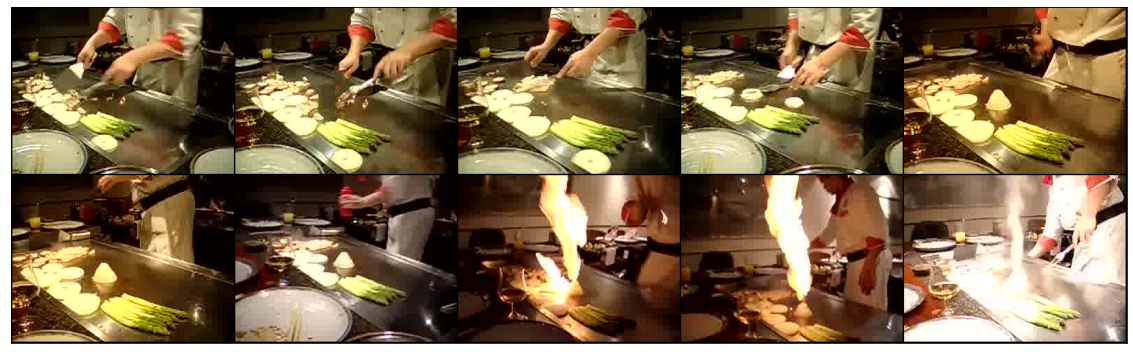

In [18]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as F


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

grid = make_grid(best_feature, nrow=5)
show(grid)